In [1]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "vscode"
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, explode, col, regexp_replace, transform, isnan

spark = SparkSession.builder.appName("LightcastCleanedData").getOrCreate()

# 重新加载处理后的数据
df_cleaned = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").csv("data/lightcast_cleaned.csv")

# 查看数据结构和样本
df_cleaned.show(5)

your 131072x1 screen size is bogus. expect trouble
25/04/20 02:21:37 WARN Utils: Your hostname, DESKTOP-AEE21PF resolves to a loopback address: 127.0.1.1; using 192.168.167.208 instead (on interface eth0)
25/04/20 02:21:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/20 02:21:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/20 02:21:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/04/20 02:21:39 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/04/20 02:21:44 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-------------------+----------------------+----------+----------+----------+--------+------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+---------

In [2]:
# 转换为 Pandas DataFrame，只取 BODY 列
body_df = df_cleaned.select("BODY").dropna().toPandas()

# 清理文本（可选）
body_df["BODY"] = body_df["BODY"].str.replace(r'\n|\r', ' ', regex=True)

# TF-IDF 提取
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(body_df["BODY"])

# 查看特征词
print(tfidf_vectorizer.get_feature_names_out()[:20])


['00' '000' '10' '100' '11' '12' '15' '20' '200' '2024' '24' '25' '30'
 '40' '401' '401k' '4hana' '50' '500' 'abilities']


生成第 0 类的词云...


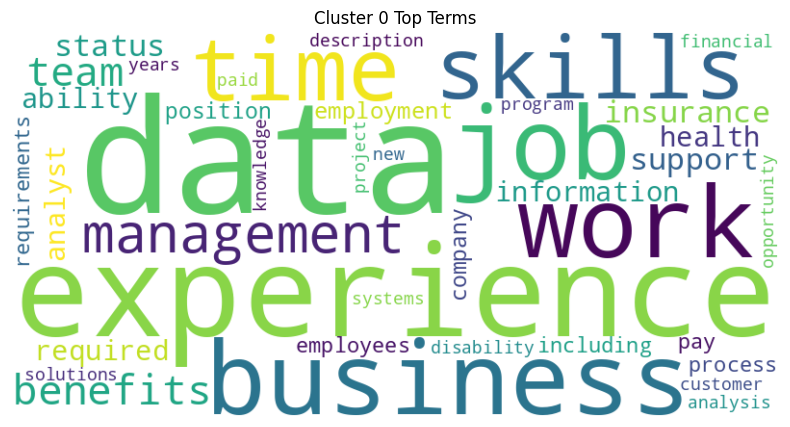

生成第 1 类的词云...


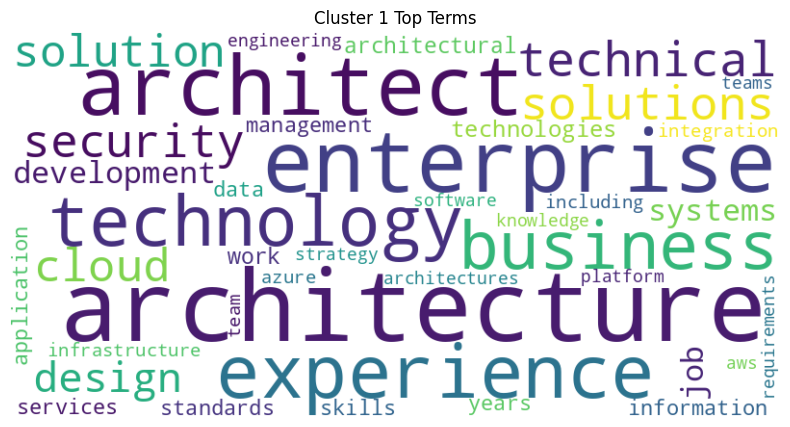

生成第 2 类的词云...


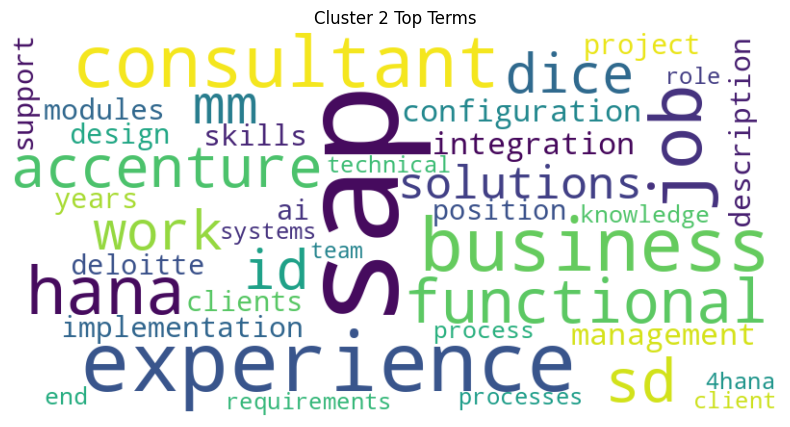

生成第 3 类的词云...


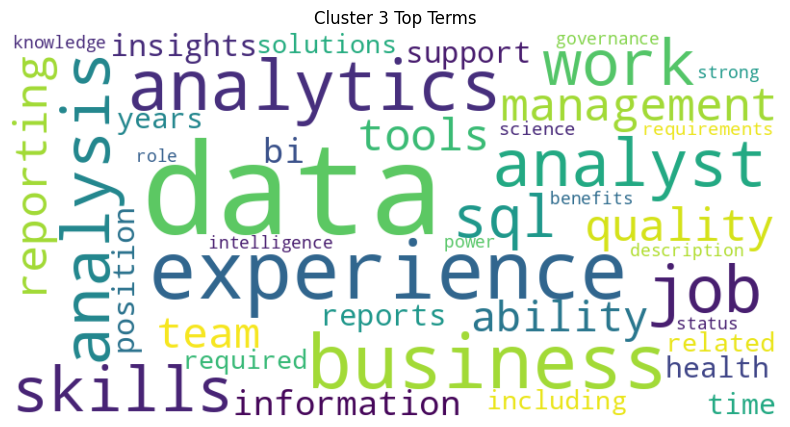

生成第 4 类的词云...


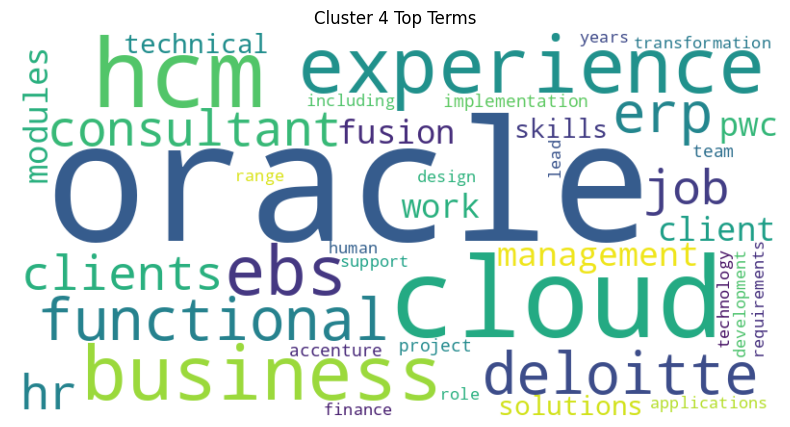

In [4]:
from sklearn.cluster import KMeans

# 聚成 5 类（你可以调整 n_clusters）
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# 把聚类结果加到原 DataFrame 中
body_df["cluster"] = clusters

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# 获取词汇表
terms = tfidf_vectorizer.get_feature_names_out()

# 获取每个聚类中心的前关键词
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

# 为每个聚类生成词云
for i in range(k):
    print(f"生成第 {i} 类的词云...")
    
    top_terms = [terms[ind] for ind in order_centroids[i, :40]]
    weights = {term: kmeans.cluster_centers_[i][terms.tolist().index(term)] for term in top_terms}

    wordcloud = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(weights)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Cluster {i} Top Terms")
    plt.show()

import plotly.express as px

fig = px.histogram(body_df, x="cluster", nbins=k, title="各主题（聚类）职位数分布")
fig.show()
